In [1]:
#6->1->6

## Imports

In [2]:
import random

import pennylane as qml
from pennylane import numpy as np

from pennylane.optimize import AdamOptimizer

import torch
from torchvision import datasets, transforms

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\tomut\anaconda3\envs\qhack2022\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e2_classic
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

## Get Data

In [4]:
input_data = get_dataset(img_width=8, img_height=8, train=True)
print("Original data set size:", len(input_data))

# Select only the pictures with numbers 0 or 1. (jus to compare with literature)
filtered_data = [image for image in input_data if image[1] in [0, 1]]
input_data = filtered_data
print("Final data set szize:", len(input_data))

Original data set size: 60000
Final data set szize: 12665


## Training node

In [5]:
shots = 2500
nr_trash=5
nr_latent=1
nr_ent=0
spec = QubitsArrangement(nr_trash, nr_latent, nr_swap=1, nr_ent=nr_ent)
print("Qubits:", spec.qubits)

#set up the device 
dev = qml.device("default.qubit", wires=spec.num_qubits)

Qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [6]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state):
    #initilaization
    setAB_amplitude(spec, *init_params)

    setAux(spec, reinit_state)

    setEnt(spec, inputs=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2)])

    #encoder

    for params in encoder_params:
        e2_classic(params, [*spec.latent_qubits, *spec.trash_qubits])

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]

## Training parameters 

In [7]:
epochs = 2000
learning_rate = 0.0003
batch_size = 5
num_samples = 20

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [8]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [9]:
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [10]:
def fidelity(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [11]:
def iterate_batches(X, batch_size):
    X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in X]
    X2 = []
    for i in range(len(X1)):
        X2.append([X1[1], X[i][1]])
    X = X2
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [12]:
training_data = [input_data[i] for i in range(num_samples)]
test_data = [input_data[i] for i in range(num_samples,num_samples+num_samples)]

In [13]:
X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in training_data]
X2 = []
for i in range(len(X1)):
    X2.append([X1[1], training_data[i][1]])
X_training = X2

X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in test_data]
X2 = []
for i in range(len(X1)):
    X2.append([X1[1], training_data[i][1]])
X_tes = X2

In [14]:
# initialize random encoder parameters
nr_encod_qubits = len(spec.trash_qubits) + len(spec.latent_qubits)
nr_par_encoder =  15 * int(nr_encod_qubits*(nr_encod_qubits-1)/2)
encoder_params = np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)


###  training

In [15]:
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\math\multi_dispatch.py:63: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch:0 | Loss:1.9430792528215732 | Fidelity:0.5146470472307734
Test-Epoch:0 | Loss:1.9674798865035679 | Fidelity:0.5082644081191152
Epoch:5 | Loss:1.907134597321938 | Fidelity:0.5243468402304868
Test-Epoch:5 | Loss:1.9424342155083074 | Fidelity:0.5148179495686621
Epoch:10 | Loss:1.863985405030587 | Fidelity:0.5364848873286057
Test-Epoch:10 | Loss:1.908785273601535 | Fidelity:0.5238933964076431
Epoch:15 | Loss:1.818233176710504 | Fidelity:0.5499844644839074
Test-Epoch:15 | Loss:1.8693887544475054 | Fidelity:0.5349342118491285
Epoch:20 | Loss:1.7752306712076655 | Fidelity:0.5633070767753879
Test-Epoch:20 | Loss:1.8293617656564762 | Fidelity:0.5466387342151238
Epoch:25 | Loss:1.7375504445916694 | Fidelity:0.5755228592715783
Test-Epoch:25 | Loss:1.7920608530248294 | Fidelity:0.5580167650624668
Epoch:30 | Loss:1.7049775060355614 | Fidelity:0.5865180018270238
Test-Epoch:30 | Loss:1.7583748526807592 | Fidelity:0.568706950327135
Epoch:35 | Loss:1.675912678958785 | Fidelity:0.5966897992688271


Test-Epoch:300 | Loss:1.140464941268193 | Fidelity:0.8768353710969874
Epoch:305 | Loss:1.1217476230582168 | Fidelity:0.8914661189775496
Test-Epoch:305 | Loss:1.1378716635880866 | Fidelity:0.8788337314303691
Epoch:310 | Loss:1.1194492608727402 | Fidelity:0.8932964047163556
Test-Epoch:310 | Loss:1.1353357400749329 | Fidelity:0.8807967235612606
Epoch:315 | Loss:1.1171947482099243 | Fidelity:0.8950990877841983
Test-Epoch:315 | Loss:1.1328540531261786 | Fidelity:0.8827262410726606
Epoch:320 | Loss:1.1149810291071325 | Fidelity:0.8968762462270694
Test-Epoch:320 | Loss:1.1304238292814295 | Fidelity:0.8846239561631183
Epoch:325 | Loss:1.1128053403011682 | Fidelity:0.898629763700956
Test-Epoch:325 | Loss:1.1280426379288495 | Fidelity:0.8864913136936536
Epoch:330 | Loss:1.1106652136233817 | Fidelity:0.9003613219663616
Test-Epoch:330 | Loss:1.1257083839648914 | Fidelity:0.8883295303157194
Epoch:335 | Loss:1.1085584737620695 | Fidelity:0.9020723973236535
Test-Epoch:335 | Loss:1.1234192957586655 | 

Epoch:605 | Loss:1.0369474646132486 | Fidelity:0.9643690101243184
Test-Epoch:605 | Loss:1.0607228882327218 | Fidelity:0.9427532969200915
Epoch:610 | Loss:1.0363188809912294 | Fidelity:0.9649539522463482
Test-Epoch:610 | Loss:1.0603985315898365 | Fidelity:0.9430416680233586
Epoch:615 | Loss:1.0357052422295498 | Fidelity:0.965525672002309
Test-Epoch:615 | Loss:1.0600841838266144 | Fidelity:0.9433213090589401
Epoch:620 | Loss:1.0351060721203509 | Fidelity:0.9660845655668522
Test-Epoch:620 | Loss:1.0597790887077811 | Fidelity:0.9435928776622011
Epoch:625 | Loss:1.0345209229588774 | Fidelity:0.9666310055284887
Test-Epoch:625 | Loss:1.0594825514081774 | Fidelity:0.9438569787401235
Epoch:630 | Loss:1.0339493724527065 | Fidelity:0.9671653435291783
Test-Epoch:630 | Loss:1.0591939351985427 | Fidelity:0.9441141671685964
Epoch:635 | Loss:1.0333910205592551 | Fidelity:0.9676879130020065
Test-Epoch:635 | Loss:1.058912657885539 | Fidelity:0.9443649507380737
Epoch:640 | Loss:1.032845486345869 | Fideli

Test-Epoch:905 | Loss:1.049081188191733 | Fidelity:0.9532150716796931
Epoch:910 | Loss:1.014842107865492 | Fidelity:0.9853749585768481
Test-Epoch:910 | Loss:1.0489924000622561 | Fidelity:0.9532957530871066
Epoch:915 | Loss:1.014641356763955 | Fidelity:0.985569919197211
Test-Epoch:915 | Loss:1.0489076518858123 | Fidelity:0.9533727761468022
Epoch:920 | Loss:1.0144443588709353 | Fidelity:0.9857613098790241
Test-Epoch:920 | Loss:1.0488268902329239 | Fidelity:0.953446187652492
Epoch:925 | Loss:1.0142510633782362 | Fidelity:0.9859491758078424
Test-Epoch:925 | Loss:1.0487500519114619 | Fidelity:0.9535160433864966
Epoch:930 | Loss:1.0140614151072 | Fidelity:0.9861335665693252
Test-Epoch:930 | Loss:1.048677064591286 | Fidelity:0.9535824075543623
Epoch:935 | Loss:1.0138753547494344 | Fidelity:0.9863145359195912
Test-Epoch:935 | Loss:1.0486078474909237 | Fidelity:0.9536453521616967
Epoch:940 | Loss:1.0136928191606043 | Fidelity:0.986492141503042
Test-Epoch:940 | Loss:1.0485423121133652 | Fidelity

Test-Epoch:1205 | Loss:1.047628646301309 | Fidelity:0.9545367087188159
Epoch:1210 | Loss:1.0072079761893489 | Fidelity:0.9928436069215621
Test-Epoch:1210 | Loss:1.047622038854183 | Fidelity:0.9545427290683295
Epoch:1215 | Loss:1.007126146969448 | Fidelity:0.9929242756819578
Test-Epoch:1215 | Loss:1.047615003409875 | Fidelity:0.9545491394692774
Epoch:1220 | Loss:1.0070452674729133 | Fidelity:0.9930040210698842
Test-Epoch:1220 | Loss:1.0476075169797336 | Fidelity:0.9545559608841041
Epoch:1225 | Loss:1.0069653346910978 | Fidelity:0.9930828456043773
Test-Epoch:1225 | Loss:1.047599557842915 | Fidelity:0.9545632131222679
Epoch:1230 | Loss:1.006886346882258 | Fidelity:0.993160750561788
Test-Epoch:1230 | Loss:1.0475911056076685 | Fidelity:0.954570914784483
Epoch:1235 | Loss:1.0068083035239508 | Fidelity:0.9932377360217222
Test-Epoch:1235 | Loss:1.0475821412798372 | Fidelity:0.9545790832003822
Epoch:1240 | Loss:1.006731205255973 | Fidelity:0.9933138009224012
Test-Epoch:1240 | Loss:1.04757264733

Epoch:1505 | Loss:1.004036512074412 | Fidelity:0.9959797158510973
Test-Epoch:1505 | Loss:1.0464524053809243 | Fidelity:0.9556096339001531
Epoch:1510 | Loss:1.004007907672833 | Fidelity:0.9960080915277615
Test-Epoch:1510 | Loss:1.0464277080923385 | Fidelity:0.9556321877437881
Epoch:1515 | Loss:1.003979802028732 | Fidelity:0.9960359740099453
Test-Epoch:1515 | Loss:1.0464031080126939 | Fidelity:0.9556546538734757
Epoch:1520 | Loss:1.003952175396034 | Fidelity:0.9960633828055852
Test-Epoch:1520 | Loss:1.0463786095310785 | Fidelity:0.9556770282681308
Epoch:1525 | Loss:1.0039250084613232 | Fidelity:0.9960903369990366
Test-Epoch:1525 | Loss:1.0463542169724307 | Fidelity:0.9556993069645628
Epoch:1530 | Loss:1.0038982823653992 | Fidelity:0.9961168552293824
Test-Epoch:1530 | Loss:1.0463299346417867 | Fidelity:0.9557214860170774
Epoch:1535 | Loss:1.0038719787217192 | Fidelity:0.9961429556718485
Test-Epoch:1535 | Loss:1.0463057668613716 | Fidelity:0.9557435614636095
Epoch:1540 | Loss:1.00384607963

Test-Epoch:1800 | Loss:1.0453099591124757 | Fidelity:0.9566540443650361
Epoch:1805 | Loss:1.0027572664883166 | Fidelity:0.9972503151256407
Test-Epoch:1805 | Loss:1.0452983921231067 | Fidelity:0.9566646304400213
Epoch:1810 | Loss:1.0027389591270004 | Fidelity:0.9972685222788339
Test-Epoch:1810 | Loss:1.045287140024963 | Fidelity:0.9566749285522815
Epoch:1815 | Loss:1.0027206695161686 | Fidelity:0.9972867124425772
Test-Epoch:1815 | Loss:1.0452762050134532 | Fidelity:0.9566849366738712
Epoch:1820 | Loss:1.0027023951771041 | Fidelity:0.9973048880803489
Test-Epoch:1820 | Loss:1.0452655892999858 | Fidelity:0.9566946527625577
Epoch:1825 | Loss:1.002684133669661 | Fidelity:0.9973230516176237
Test-Epoch:1825 | Loss:1.0452552951077732 | Fidelity:0.9567040747656709
Epoch:1830 | Loss:1.0026658825957298 | Fidelity:0.9973412054384172
Test-Epoch:1830 | Loss:1.0452453246666946 | Fidelity:0.9567132006248176
Epoch:1835 | Loss:1.0026476396028845 | Fidelity:0.9973593518816507
Test-Epoch:1835 | Loss:1.0452

## Rezults

In [16]:
import matplotlib.pyplot as plt

fidelity: 0.9979462214891297


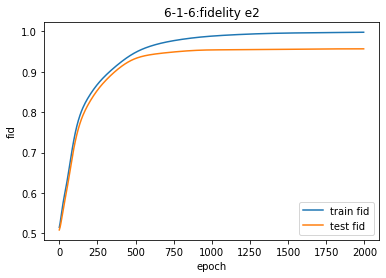

In [17]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fid")


plt.legend()
plt.title("6-1-6:fidelity e2",)
plt.xlabel("epoch")
plt.ylabel("fid")

print("fidelity:",fid_hist[-1])

loss: 1.002058005197721


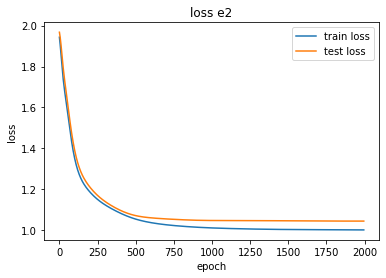

In [18]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("loss e2",)
plt.xlabel("epoch")
plt.ylabel("loss")

print("loss:",loss_hist[-1])

In [19]:
name = "training_e2"

Circuit_prop={   "shots":shots, "nr_trash":nr_trash, "nr_latent":nr_latent ,"nr_ent":nr_ent  }
Training_param = { "num_samples": num_samples,
                    "batch_size": batch_size,
                    "nr_layers": 1,
                    "epochs": epochs,
                    "learning_rate":learning_rate ,
                    "beta1":beta1,
                    "beta2 ":beta2,
                     "optimizer":"Adam"}

performance={"loss_hist":loss_hist, "fid_hist":fid_hist,
             "loss_hist_test":loss_hist_test, "fid_hist_test":fid_hist_test,
             "encoder_params":encoder_params}

experiment_data={"Circuit_prop":Circuit_prop,
                "Training_param":Training_param,
                "performance:":performance,
                "Name":name}

# open file for writing
f = open(name+".txt","w")
f.write( str(experiment_data) )

67534